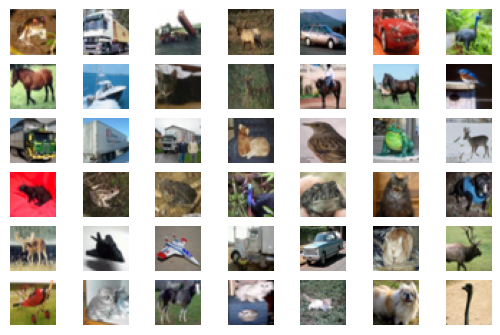

In [37]:
#Example of loading and plotting the cifar10 dataset

from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
#load the images into memory
(trainX, trainY), (testX, testY) = load_data()
#plot image from the training dataset
for i in range(42):
  #define subplots
  pyplot.subplot(7,7,1+i)
  #trun of axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(trainX[i])
pyplot.show()

In [38]:
# Size of Training data
trainX.shape

(50000, 32, 32, 3)

In [39]:
#Example of defining the discriminator model

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model
import numpy as np

**Discriminator Model**

In [40]:
# define the standalone discriminator model which is CNN network

# Input size is 32 * 32 *3 as cifar dataset is 32 *32 *3
# LeakyRelu works better for GAN instead of Relu
# Since the output of Discriminator is binary(1,0) hence we have used sigmoid activation
# Compile the model with learning_rate as .0002 with adam optimizer

def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #normal
  model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape= in_shape))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #downsample
  model.add(Conv2D(256, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))

  # Binary Classfication
  model.add(Dense(1,activation='sigmoid'))

  # Model Compilation
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

  return model


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 256)        

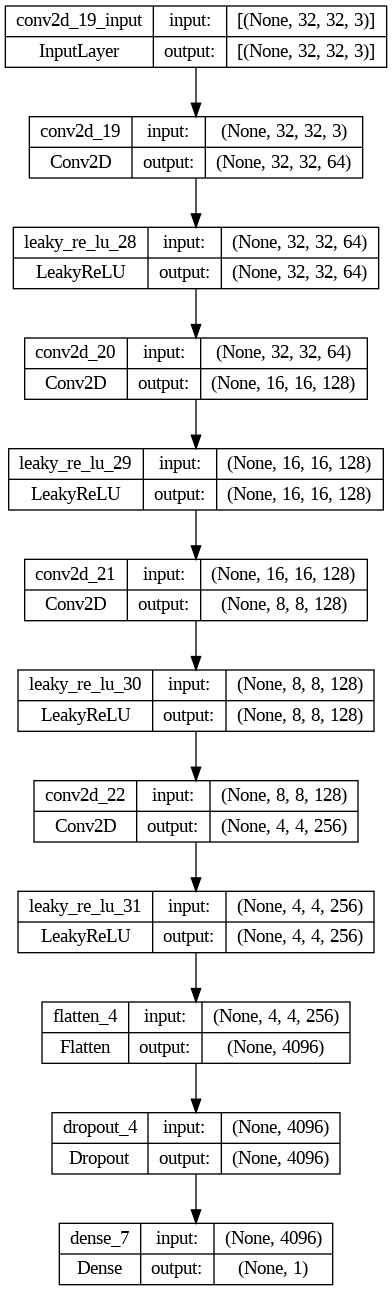

In [42]:
#define discriminator model

model = define_discriminator()
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
# Function to load and prepare cifar10 training images and scale the dataset

# Only Trainx is taken and not trainY cause its unsupervised learning and secondly TrainY will contain only 1 or 0 (1 for Real Image, 0 for FakeImage )

def load_real_samples():
  #load cifar10 dataset
  (trainX,_), (_,_) = load_data()
  #convert from unsigned int to float
  X = trainX.astype('float32')
  #scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5

  return X

In [44]:
# call load_real_samples data function to load the cifar10 dataset and scale it down

x = load_real_samples()
x.shape

(50000, 32, 32, 3)

In [45]:
# Printing scaled down cifar10 dataset

x[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

In [46]:
# Generate_real_samples function

# This function generate dataset x1 from our cifar dataset, which was scaled down.
# Instead of picking all 50k images, batch size of 64 is chosen as  we donot want complete 50k image to be loaded into memory
# dataset y1 is prepared which are all 1 as objective of GAN is generate real image which is signified by 1

def generate_real_samples(dataset,n_samples):
  #choose random index
  index = np.random.randint(0, dataset.shape[0], n_samples)
  #retrive selected images
  X = dataset[index]
  #generate real class labels: (1)
  y = np.ones((n_samples,1))

  return X,y

In [47]:
# calling generate_real_samples function to generate  dataset x1 in batch of 64 as well has initialize dataset y1 with all 1's

x1,y1 = generate_real_samples(x,64)
print(x1.shape)
print(y1.shape)

(64, 32, 32, 3)
(64, 1)


In [48]:
# printing x1 dataset
x1

array([[[[-0.77254903, -0.7882353 , -0.62352943],
         [-0.8352941 , -0.8745098 , -0.73333335],
         [-0.85882354, -0.90588236, -0.7490196 ],
         ...,
         [ 0.37254903,  0.43529412,  0.5686275 ],
         [ 0.37254903,  0.46666667,  0.5921569 ],
         [ 0.3882353 ,  0.5058824 ,  0.67058825]],

        [[-0.81960785, -0.8509804 , -0.7019608 ],
         [-0.85882354, -0.92156863, -0.8117647 ],
         [-0.827451  , -0.8901961 , -0.8039216 ],
         ...,
         [ 0.48235294,  0.5529412 ,  0.6862745 ],
         [ 0.4745098 ,  0.5686275 ,  0.69411767],
         [ 0.4745098 ,  0.5921569 ,  0.75686276]],

        [[-0.8117647 , -0.85882354, -0.7254902 ],
         [-0.73333335, -0.81960785, -0.7490196 ],
         [-0.64705884, -0.7411765 , -0.7176471 ],
         ...,
         [ 0.49019608,  0.56078434,  0.69411767],
         [ 0.49019608,  0.5764706 ,  0.70980394],
         [ 0.48235294,  0.5921569 ,  0.7490196 ]],

        ...,

        [[-0.03529412, -0.12941177, -0

In [49]:
# printing y1 dataset
y1

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [50]:
# Generate_fake_samples function

# This function generate x2 datasets with batch size of 64 using rand function
# y2 is set to 0 as we want to feed discriminator with fake images  which are signified by 1

def generate_fake_samples(n_samples):
  #generate uniform random numbers in  range(0,1]
  X = np.random.rand(32 * 32 *3 * n_samples)
  #update to have the range [-1,1]
  X = -1 + X * 2
  # reshape into a batch of color images
  X = X.reshape((n_samples, 32,32,3))
  #generate fake class labels: (0)
  y = np.zeros((n_samples, 1))
  return X, y

In [51]:
# calling generate_fake_samples function to generate  dataset x2 in batch of 64 as well has initialize dataset y2 with all 0's

x2,y2 = generate_fake_samples(64)
print(x2.shape)
print(y2.shape)

(64, 32, 32, 3)
(64, 1)


In [52]:
# printing x2 dataset
x2

array([[[[-0.47734897,  0.90558018, -0.5502417 ],
         [ 0.11883826, -0.37740586,  0.48834003],
         [-0.96792775, -0.71134403, -0.31540941],
         ...,
         [-0.83249352, -0.86564712,  0.7061456 ],
         [-0.17116491,  0.40844252, -0.73981997],
         [ 0.45512031,  0.02612525,  0.0473293 ]],

        [[-0.33645543, -0.40211485, -0.20357841],
         [-0.43817857,  0.34610095, -0.10835462],
         [-0.7404357 , -0.43252382, -0.49198392],
         ...,
         [ 0.32781255,  0.08195391, -0.07241423],
         [ 0.93027054,  0.2908526 , -0.09463295],
         [ 0.15270045,  0.22278167, -0.55161754]],

        [[ 0.22473384, -0.81270215,  0.341115  ],
         [-0.46117866, -0.66255324,  0.07742372],
         [ 0.05540972,  0.44462455,  0.0310952 ],
         ...,
         [-0.28281721, -0.08559588,  0.7811734 ],
         [-0.30103323,  0.25481686, -0.06496371],
         [-0.05214112,  0.94479348,  0.82171592]],

        ...,

        [[-0.04418773, -0.83435009, -0

In [53]:
# printing y2 dataset
y2

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

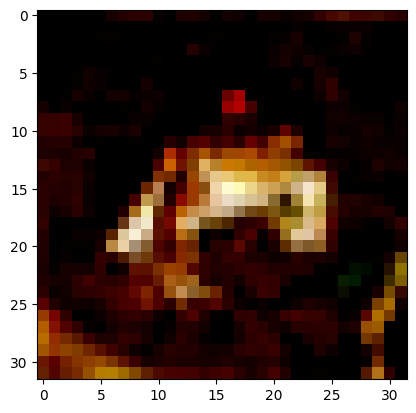

In [58]:
 # printing fake image generated by random module
 pyplot.imshow(x[0])


In [55]:
# Defining Train discriminator model

def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)
  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly selected real samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    #update discriminator on real samples
    _,real_acc = model.train_on_batch(X_real, y_real)
    #generates fake examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    #update discriminator on fake samples
    _,fake_acc = model.train_on_batch(X_fake, y_fake)
    #summarize performance
    print('>%d real = %.0f%% fake= %.0f%%' % (i+1, real_acc*100, fake_acc*100))

Discriminator function is called with real cifar dataset and fake image generated from random module

In [56]:
# calling Train discriminator model with real

#define the discriminator model
model = define_discriminator()
#load cifar10 image data
dataset = load_real_samples()
#train the model
train_discriminator(model, dataset)

>1 real = 55% fake= 0%
>2 real = 98% fake= 0%
>3 real = 98% fake= 16%
>4 real = 100% fake= 44%
>5 real = 98% fake= 69%
>6 real = 92% fake= 98%
>7 real = 98% fake= 100%
>8 real = 95% fake= 100%
>9 real = 98% fake= 100%
>10 real = 97% fake= 100%
>11 real = 100% fake= 100%
>12 real = 98% fake= 100%
>13 real = 94% fake= 100%
>14 real = 97% fake= 100%
>15 real = 97% fake= 100%
>16 real = 100% fake= 100%
>17 real = 100% fake= 100%
>18 real = 100% fake= 100%
>19 real = 100% fake= 100%
>20 real = 100% fake= 100%


Note : Inference from Discriminator model is its able to idendify Real and Fake image with 100% accuracy after training model for 20 iterations

**Generator Model**

In [22]:
# now work on Generator
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

In [60]:
#define the standalone generator model
# purpose is to upsample input image from 4*4 to 32*32 which will be used by discriminator
def define_generator(latent_dim):
  model = Sequential()
  #Input image dimension is 4x4
  n_nodes = 256 * 4* 4
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))

  #upsample image from 4*4 to 8x8  which will be done using CONV2D Transpose
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))


  #upsample image from 8*8 to 16x16  which will be done using CONV2D Transpose
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))

  #upsample image from 16*16 to 32x32  which will be done using CONV2D Transpose
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 8, 8, 128)         524416    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_13 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                         

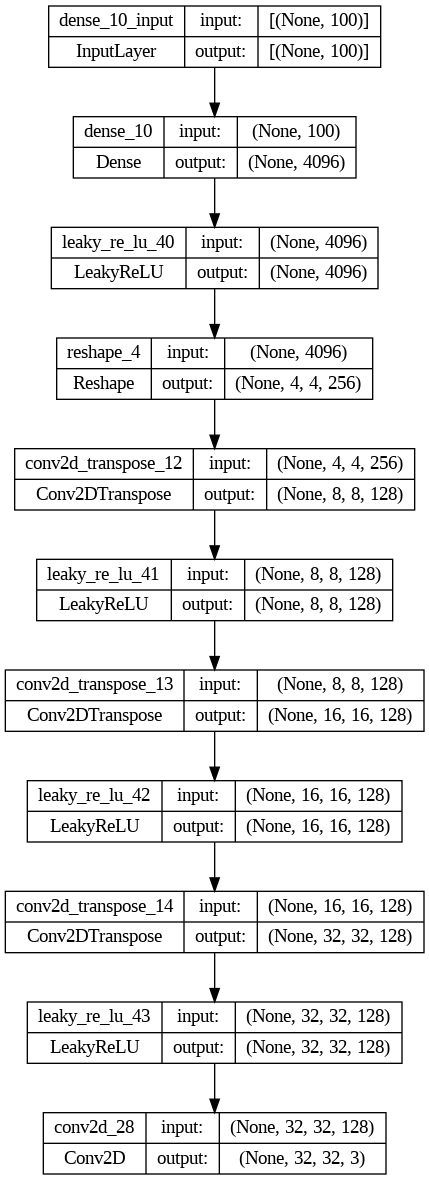

In [61]:
#define the size of the latent dimension which we have set to 100
latent_dim = 100
#define the generator model
model = define_generator(latent_dim)
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


In [62]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  #generate point in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  #reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input

In [68]:
# call generate_latent_points
data = generate_latent_points(100,64)
print(data.shape)

(64, 100)


In [66]:
data[0]

array([-1.22305293,  1.13590118,  0.46333284,  0.89099619,  1.10053243,
       -1.74418106, -0.625884  ,  0.93231955,  0.05084716, -0.31764348,
       -0.58521971,  0.50855099,  1.24208977, -1.2613642 , -0.07653409,
        0.40501577,  0.09004709,  1.57324259, -1.43995532, -1.74731627,
       -0.53377763, -0.65771054, -0.56925818, -0.03174895, -0.28706627,
        2.00667822,  0.36971268, -1.35396395, -0.41022157, -0.04606121,
       -0.23152311, -1.18498896,  0.44348307, -0.28902194, -1.03010154,
       -0.28492113,  0.57585579,  1.45967984,  0.22518184,  1.39111427,
       -1.6098354 ,  1.11449578,  0.28333851,  0.79861968, -1.51292076,
       -0.37403266, -1.3327108 , -0.20414494, -1.53262589, -0.12700016,
       -1.2257613 ,  0.56592589,  0.62839747, -1.69089488, -0.26153597,
       -0.6279312 ,  0.54374146,  0.39909515, -0.00710133,  1.10849046,
       -0.16929978, -1.12012387,  0.14404794,  1.44023014,  0.837533  ,
        0.45645998, -1.26058507,  0.24492651, -0.48037649, -0.06

In [28]:
#use the generator to generate n fake examples with class labels
def generate_fake_images(g_model, latent_dim, n_sample):
  #generate point in the latent space
  x_input = generate_latent_points(latent_dim, n_sample)
  #predict output from generator
  X = g_model.predict(x_input)
  #create a fake class label: (0)
  y = np.zeros((n_sample,1))

  return X,y


2/2 [==============================] - 0s 6ms/step


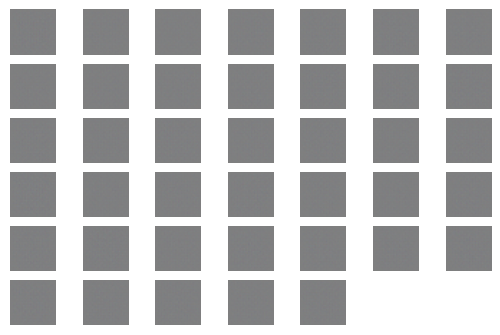

In [69]:
#size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
#generate samples
n_sample = 40
X,_ = generate_fake_images(model, latent_dim, n_sample)
#scale the pixel value from [-1,1] to [0,1]
X = (X + 1) / 2.0
#plot the generated samples
for i in range(n_sample):
  #define subplots
  pyplot.subplot(7,7,1+i)
  #turn of axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(X[i])
pyplot.show()


**Combining Generator and Discriminator**

In [30]:
#defining the combined generator and discriminator model, for updating the generator
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable = False
  #connect them
  model = Sequential()
  #add generator
  model.add(g_model)
  #add discriminator
  model.add(d_model)
  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam)

  return model


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


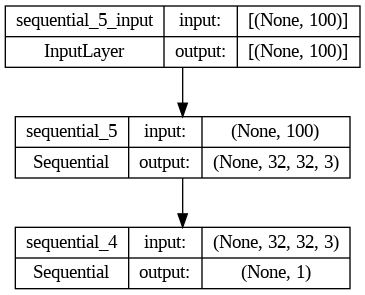

In [31]:
# size of the latent space
latent_dim = 100
#create discriminator
d_model = define_discriminator()
#create generator
g_model = define_generator(latent_dim)
#create the GAN
gan_model = define_gan(g_model, d_model)
#summarize the gan
gan_model.summary()
#plot the gan model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [70]:
#train the generator & dicriminator
def train(g_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected real samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      #update discriminator model weights
      d_loss1,_ = d_model.train_on_batch(X_real, y_real)
      #generate fake examples
      X_fake, y_fake = generate_fake_images(g_model,latent_dim, half_batch)
      #update discriminator model weights
      d_loss2,_ = d_model.train_on_batch(X_fake, y_fake)
      #prepare points in the latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for fake samples
      y_gan = np.ones((n_batch,1))
      #update the generator via the discriminator'r error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      #summarize loss on this batches
      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
            (i+i, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    #evaluate the model performance sometimes
    if (i+1) % 10 ==0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)




In [71]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epochs, g_model, d_model, dataset, latent_dim, n_sample=150):
  #prepare real sample
  X_real, y_real = generate_real_samples(dataset, n_sample)
  #evaluate dicriminator on real examples
  _,acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  #prepare fake examples
  X_fake, y_fake = generate_fake_images(g_model,latent_dim, n_sample)
  #evaluate dicriminator on fake examples
  _,acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
  #save plot
  save_plot(X_fake, epochs)
  # save the generator model title file
  filename = 'generator_model_%03d.h5' % (epochs+1)
  g_model.save(filename)



In [72]:
# create and save a plot of generated images
def save_plot(examples, epochs,n=7):
  #scale the pixel value from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  #plot the generated samples
  for i in range(n*n):
    #define subplots
    pyplot.subplot(n,n,1+i)
    #turn of axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i])
  #save plot as file
  filename = 'generated_plot_%03d.png' % (epochs+1)
  pyplot.savefig(filename)
  pyplot.close()




In [ ]:
train(g_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
>6, 232/390, d1=0.545, d2=0.506, g=1.089
2/2 [==============================] - 0s 12ms/step
>6, 233/390, d1=0.615, d2=0.535, g=1.113
2/2 [==============================] - 0s 9ms/step
>6, 234/390, d1=0.708, d2=0.523, g=1.121
2/2 [==============================] - 0s 4ms/step
>6, 235/390, d1=0.654, d2=0.575, g=1.029
2/2 [==============================] - 0s 10ms/step
>6, 236/390, d1=0.548, d2=0.650, g=1.050
2/2 [==============================] - 0s 9ms/step
>6, 237/390, d1=0.644, d2=0.581, g=1.057
2/2 [==============================] - 0s 4ms/step
>6, 238/390, d1=0.502, d2=0.560, g=1.099
2/2 [==============================] - 0s 10ms/step
>6, 239/390, d1=0.683, d2=0.528, g=1.039
2/2 [==============================] - 0s 4ms/step
>6, 240/390, d1=0.568, d2=0.743, g=1.053
2/2 [==============================] - 0s 9ms/step
>6, 241/390, d1=0.656, d2=0.642, g=1.075
2/2 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
>26, 232/390, d1=0.718, d2=0.614, g=0.842
2/2 [==============================] - 0s 5ms/step
>26, 233/390, d1=0.710, d2=0.660, g=0.841
2/2 [==============================] - 0s 17ms/step
>26, 234/390, d1=0.731, d2=0.660, g=0.870
2/2 [==============================] - 0s 13ms/step
>26, 235/390, d1=0.664, d2=0.620, g=0.847
2/2 [==============================] - 0s 9ms/step
>26, 236/390, d1=0.663, d2=0.584, g=0.838
2/2 [==============================] - 0s 5ms/step
>26, 237/390, d1=0.664, d2=0.650, g=0.796
2/2 [==============================] - 0s 4ms/step
>26, 238/390, d1=0.650, d2=0.712, g=0.792
2/2 [==============================] - 0s 5ms/step
>26, 239/390, d1=0.646, d2=0.694, g=0.795
2/2 [==============================] - 0s 7ms/step
>26, 240/390, d1=0.609, d2=0.674, g=0.824
2/2 [==============================] - 0s 6ms/step
>26, 241/390, d1=0.618, d2=0.651, g=0.813
2/2 [============

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>46, 232/390, d1=0.570, d2=0.709, g=0.809
2/2 [==============================] - 0s 4ms/step
>46, 233/390, d1=0.705, d2=0.705, g=0.792
2/2 [==============================] - 0s 6ms/step
>46, 234/390, d1=0.714, d2=0.631, g=0.825
2/2 [==============================] - 0s 13ms/step
>46, 235/390, d1=0.680, d2=0.676, g=0.843
2/2 [==============================] - 0s 11ms/step
>46, 236/390, d1=0.682, d2=0.614, g=0.846
2/2 [==============================] - 0s 6ms/step
>46, 237/390, d1=0.716, d2=0.636, g=0.840
2/2 [==============================] - 0s 4ms/step
>46, 238/390, d1=0.670, d2=0.660, g=0.840
2/2 [==============================] - 0s 4ms/step
>46, 239/390, d1=0.729, d2=0.665, g=0.861
2/2 [==============================] - 0s 12ms/step
>46, 240/390, d1=0.754, d2=0.642, g=0.862
2/2 [==============================] - 0s 4ms/step
>46, 241/390, d1=0.746, d2=0.664, g=0.824
2/2 [===========

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
>66, 232/390, d1=0.642, d2=0.669, g=0.780
2/2 [==============================] - 0s 5ms/step
>66, 233/390, d1=0.705, d2=0.701, g=0.778
2/2 [==============================] - 0s 8ms/step
>66, 234/390, d1=0.701, d2=0.657, g=0.780
2/2 [==============================] - 0s 5ms/step
>66, 235/390, d1=0.655, d2=0.678, g=0.795
2/2 [==============================] - 0s 5ms/step
>66, 236/390, d1=0.630, d2=0.665, g=0.838
2/2 [==============================] - 0s 5ms/step
>66, 237/390, d1=0.669, d2=0.628, g=0.843
2/2 [==============================] - 0s 4ms/step
>66, 238/390, d1=0.687, d2=0.637, g=0.841
2/2 [==============================] - 0s 13ms/step
>66, 239/390, d1=0.704, d2=0.653, g=0.795
2/2 [==============================] - 0s 4ms/step
>66, 240/390, d1=0.622, d2=0.688, g=0.797
2/2 [==============================] - 0s 4ms/step
>66, 241/390, d1=0.711, d2=0.678, g=0.811
2/2 [============

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>86, 232/390, d1=0.748, d2=0.606, g=0.862
2/2 [==============================] - 0s 10ms/step
>86, 233/390, d1=0.711, d2=0.667, g=0.878
2/2 [==============================] - 0s 5ms/step
>86, 234/390, d1=0.705, d2=0.599, g=0.882
2/2 [==============================] - 0s 5ms/step
>86, 235/390, d1=0.739, d2=0.636, g=0.861
2/2 [==============================] - 0s 9ms/step
>86, 236/390, d1=0.712, d2=0.636, g=0.846
2/2 [==============================] - 0s 5ms/step
>86, 237/390, d1=0.679, d2=0.669, g=0.914
2/2 [==============================] - 0s 11ms/step
>86, 238/390, d1=0.729, d2=0.594, g=0.895
2/2 [==============================] - 0s 13ms/step
>86, 239/390, d1=0.724, d2=0.588, g=0.836
2/2 [==============================] - 0s 4ms/step
>86, 240/390, d1=0.626, d2=0.697, g=0.820
2/2 [==============================] - 0s 6ms/step
>86, 241/390, d1=0.659, d2=0.635, g=0.788
2/2 [===========

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 7ms/step
>102, 129/390, d1=0.675, d2=0.667, g=0.867
2/2 [==============================] - 0s 4ms/step
>102, 130/390, d1=0.686, d2=0.680, g=0.882
2/2 [==============================] - 0s 4ms/step
>102, 131/390, d1=0.616, d2=0.677, g=0.875
2/2 [==============================] - 0s 13ms/step
>102, 132/390, d1=0.695, d2=0.626, g=0.839
2/2 [==============================] - 0s 4ms/step
>102, 133/390, d1=0.678, d2=0.633, g=0.856
2/2 [==============================] - 0s 5ms/step
>102, 134/390, d1=0.652, d2=0.622, g=0.818
2/2 [==============================] - 0s 7ms/step
>102, 135/390, d1=0.682, d2=0.652, g=0.808
2/2 [==============================] - 0s 5ms/step
>102, 136/390, d1=0.639, d2=0.662, g=0.815
2/2 [==============================] - 0s 4ms/step
>102, 137/390, d1=0.668, d2=0.641, g=0.827
2/2 [==============================] - 0s 4ms/step
>102, 138/390, d1=0.627, d2=0.617, g=0.828
2/2 [===

# Generation after training

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


def create_plot(examples, n):
  for i in range(n * n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis("off")
    pyplot.imshow(examples[i, :, :])
  pyplot.show()


#load model
model = load_model("/content/generator_model_010.h5")
latent_point = generate_latent_points(100,100)
X = model.predict(latent_point)

X = (X+1)/2.0
create_plot(X,1)

X.shape[0]